In [21]:
from numpyro.distributions import constraints
import numpyro as npy
from jax import numpy as jnp
from jax.lax import scan
from ghgf.hgf_jax import (
    loop_inputs,
)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
import os

import jax.numpy as jnp
from jax import random, grad, jit
import matplotlib.pyplot as plt
from numpy import loadtxt
import pandas as pd
import seaborn as sns

## Loading the USD/CHF time series

In [22]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
timeserie = loadtxt(f"/home/nicolas/git/ghgf/tests/data/usdchf.dat")
data = jnp.array([timeserie, jnp.arange(1, len(timeserie) + 1, dtype=float)]).T

## Creating the HGF log probability function
We first start by creating the HGF log probability funtion that will be part of the model we want to sample using e.g Hamiltonian Monte Carlo. This model has one input node that is conneted to a value parent and a volatility parent. The function accept values for omegas, rhos and pis parameters. Those values will be sampled from fixed distribution.

In [23]:
@jit
def log_prob(omega_1, omega_2, rho_1, rho_2, pi_1, pi_2):

        # First level
        vo_pa_1 = {
            "mu": jnp.array(1.0),
            "muhat": jnp.nan,
            "pi": jnp.array(pi_2),
            "pihat": jnp.nan,
            "kappas": None,
            "nu": jnp.array(1.0),
            "psis": (jnp.array(1.0),),
            "omega": jnp.array(omega_1),
            "rho": jnp.array(rho_2),
        }
        va_pa = {
            "mu": jnp.array(1.0),
            "muhat": jnp.nan,
            "pi": jnp.array(pi_1),
            "pihat": jnp.nan,
            "kappas": (jnp.array(1.0),),
            "nu": jnp.array(1.0),
            "psis": None,
            "omega": jnp.array(omega_2),
            "rho": jnp.array(rho_1),
        }

        volatility_parent_1 = vo_pa_1, None, None
        value_parent_1 = va_pa, None, None

        # Input node
        input_node_parameters = {
            "mu": jnp.array(1.04),
            "muhat": jnp.nan,
            "pi": jnp.array(1e4),
            "pihat": jnp.nan,
            "kappas": jnp.array(1.0),
            "nu": jnp.array(1.0),
            "psis": jnp.array(1.0),
            "omega": jnp.log(1e-4),
        }
        input_node = input_node_parameters, value_parent_1, volatility_parent_1

        ##############
        # Input data #
        ##############

        res_init = (
            input_node,
            {
                "time": jnp.array(0.0),
                "value": jnp.array(0.0),
                "surprise": jnp.array(0.0),
            },
        )

        # This is where the HGF functions are used to scan the input time series
        _, final = scan(loop_inputs, res_init, data)

        _, results = final
        surprise = jnp.sum(results["surprise"])

        return jnp.where(jnp.isnan(surprise), -jnp.inf, -surprise)

The critical part here is the final line

```python
    _last_, final = scan(loop_inputs, res_init, data)
```

this is where the JAX scan function is used to loop across the time series by applying the update HGF function that update the node structure while passing and accumulating previous iteration results. The final results contain a `surprise` time series whose (negative) sum is used to estimate the model fit.

## Automatic differentiation of the log probability
Under the hood, the `log_prob` function wrap a HGF model using JAX code, which make it fast because JIT compiled (note the `@jit` decorator) and optimized for CPU, GPU or TPU depending on the setup. 

In [24]:
log_prob(-10.0, -2.0, 0.0, 0.0, 1.0, 1.0)  # Fit the HGF to the data, return the negative sum of the surprise

DeviceArray(1927.8772, dtype=float32)

In [25]:
%timeit log_prob(-10.0, -2.0, 0.0, 0.0, 1.0, 1.0)

31.7 µs ± 15.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


It also make the code fully differentiable. This can be assessed using the JAX `grad` function.

In [26]:
grad(log_prob)(-10.0, -2.0, 0.0, 0.0, 1.0, 1.0)

DeviceArray(0.19776966, dtype=float32, weak_type=True)

## Parameters estimation using NUTS
### Create the full HGF distribution
Here, the critical part is the `log_prob` method that should return the model surprise.

In [27]:
class HGF(npy.distributions.Distribution):

    support = constraints.real
    has_rsample = False

    def __init__(self, omega_1=None, omega_2=None, rho_1=None, rho_2=None, pi_1=None, pi_2=None):
        self.omega_1 = omega_1
        self.omega_2 = omega_2
        self.rho_1 = rho_1
        self.rho_2 = rho_2
        self.pi_1 = pi_1
        self.pi_2 = pi_2
        super().__init__(batch_shape = (1,), event_shape=())

    def sample(self, key, sample_shape=()):
        raise NotImplementedError
        
    def log_prob(self, value):

        return log_prob(
            omega_1=self.omega_1, omega_2=self.omega_2,
            rho_1=self.rho_1, rho_2=self.rho_2,
            pi_1=self.pi_1, pi_2=self.pi_2
            )

### Create the full Bayesian model
Here we use Numpyro to build a full Bayesian model (which is simply a Python function) wrapping the HGF distribution. The omegas, rhos and pis parameter are picked from distributions and the posterior distributions are estimated given the HGF model fit.

In [28]:
def model(data=data):

    omega_1 = npy.sample("omega_1", dist.Normal(0.0, .1))
    omega_2 = npy.sample("omega_2", dist.Normal(0.0, .1))
    rho_1 = npy.sample("rho_1", dist.Normal(0.0, .1))
    rho_2 = npy.sample("rho_2", dist.Normal(0.0, .1))
    pi_1 = npy.sample("pi_1", dist.HalfNormal(1.0))
    pi_2 = npy.sample("pi_2", dist.HalfNormal(1.0))

    npy.sample("hgf_log_prob", HGF(
        omega_1=omega_1, omega_2=omega_2, rho_1=rho_1, rho_2=rho_2,
        pi_1=pi_1, pi_2=pi_2)
        )

### Use NUST to sample the model
Here we use NUTS to sample this model, for now using a large nuber of warmups.

In [29]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 1000
mcmc = MCMC(kernel, num_warmup=5000, num_samples=num_samples)
mcmc.run(
    rng_key_, data=data
)

sample: 100%|██████████| 6000/6000 [01:26<00:00, 69.30it/s, 31 steps of size 1.09e-01. acc. prob=0.94]   


### Plot results

In [30]:
samples_1 = mcmc.get_samples(group_by_chain=True)

array([[<AxesSubplot:title={'center':'hgf_log_prob'}>,
        <AxesSubplot:title={'center':'hgf_log_prob'}>],
       [<AxesSubplot:title={'center':'omega_1'}>,
        <AxesSubplot:title={'center':'omega_1'}>],
       [<AxesSubplot:title={'center':'omega_2'}>,
        <AxesSubplot:title={'center':'omega_2'}>],
       [<AxesSubplot:title={'center':'pi_1'}>,
        <AxesSubplot:title={'center':'pi_1'}>],
       [<AxesSubplot:title={'center':'pi_2'}>,
        <AxesSubplot:title={'center':'pi_2'}>],
       [<AxesSubplot:title={'center':'rho_1'}>,
        <AxesSubplot:title={'center':'rho_1'}>],
       [<AxesSubplot:title={'center':'rho_2'}>,
        <AxesSubplot:title={'center':'rho_2'}>]], dtype=object)

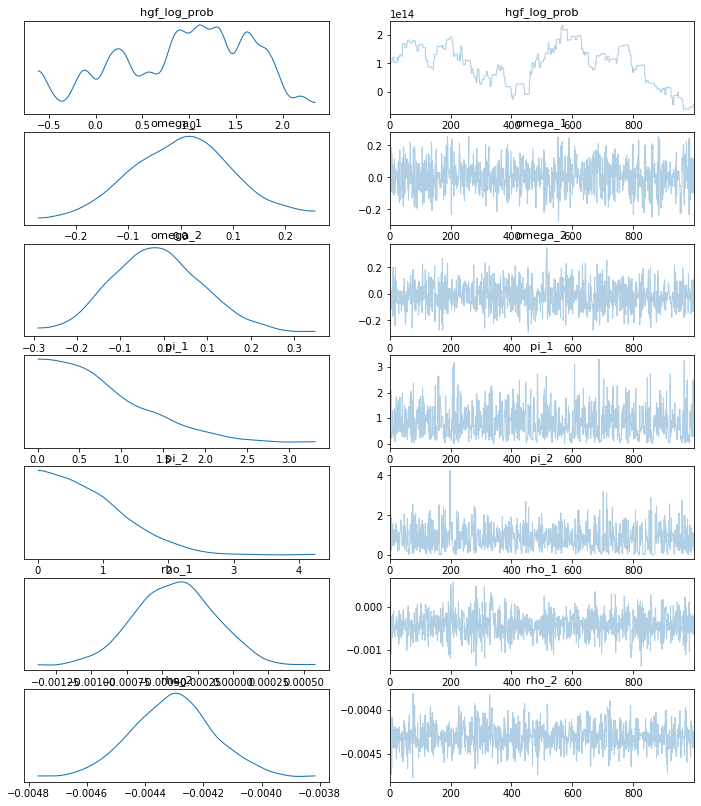

In [31]:
az.plot_trace(samples_1)

array([[<AxesSubplot:title={'center':'hgf_log_prob\n0'}>,
        <AxesSubplot:title={'center':'omega_1'}>,
        <AxesSubplot:title={'center':'omega_2'}>],
       [<AxesSubplot:title={'center':'pi_1'}>,
        <AxesSubplot:title={'center':'pi_2'}>,
        <AxesSubplot:title={'center':'rho_1'}>],
       [<AxesSubplot:title={'center':'rho_2'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

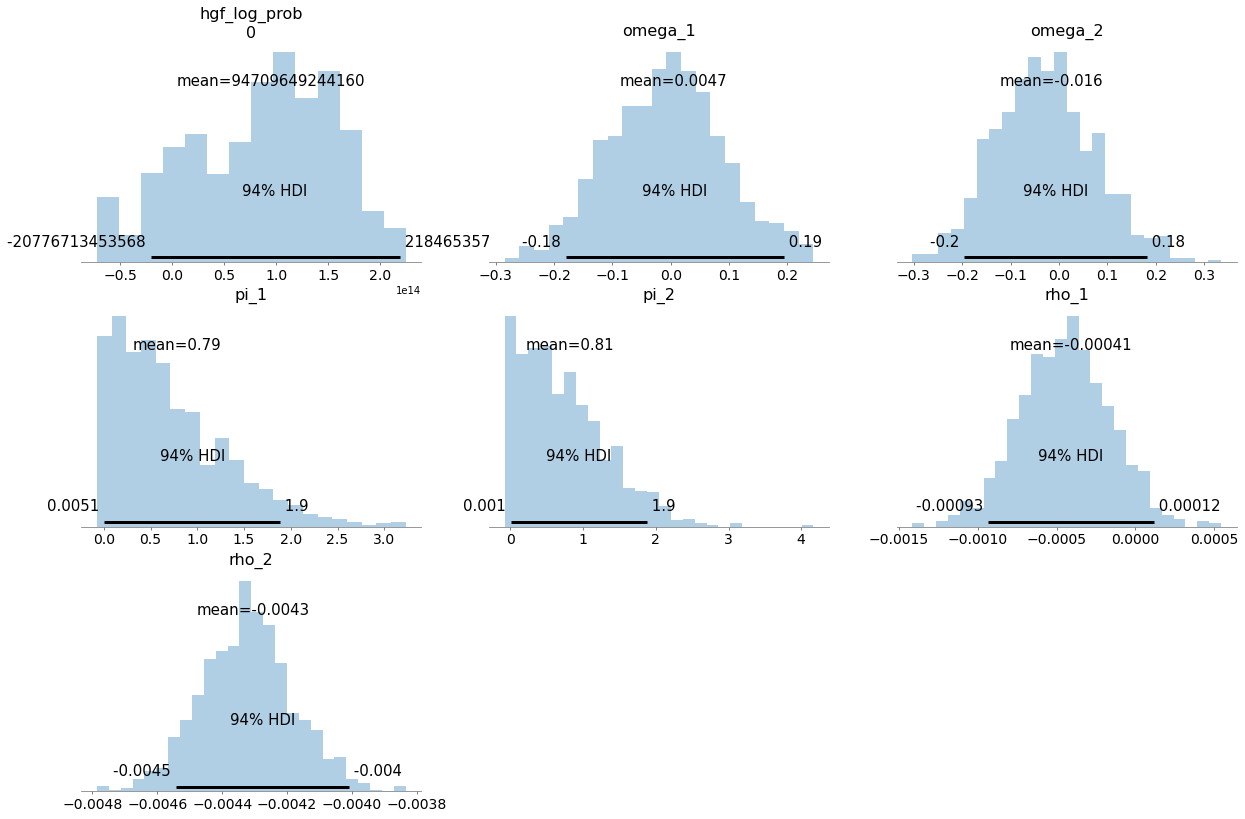

In [32]:
az.plot_posterior(samples_1, kind="hist")

In [33]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
hgf_log_prob[0] 94709649244160.00 68747834425344.00 104145952440320.00 -12584187068416.00 196721397202944.00      7.94      1.00
        omega_1      0.00      0.10      0.01     -0.18      0.15    777.47      1.00
        omega_2     -0.02      0.10     -0.02     -0.19      0.14   1036.56      1.00
           pi_1      0.79      0.61      0.64      0.01      1.63    884.72      1.00
           pi_2      0.81      0.60      0.71      0.00      1.62    892.34      1.00
          rho_1     -0.00      0.00     -0.00     -0.00      0.00    787.66      1.00
          rho_2     -0.00      0.00     -0.00     -0.00     -0.00    828.41      1.00

Number of divergences: 0
